# Part I: Simulate view of scene with perspective projection


- Using right-handed coordinates in this example
- E matrix is now E = TR (translation and rotation)

In [33]:
from google.colab import files
src = list(files.upload().values())[0]
open('helpers.py','wb').write(src)
import helpers

Saving helpers.py to helpers.py


In [26]:
import numpy as np
from helpers import projectPoints, transform_camera
from math import sin, cos, pi

# Define n random points in 1x1x1 cube centred at (0,0,2): 
# n = 20
# np.random.rand(n,3) - 0.5 + np.array([[0,0,2.0]])

p = np.array([[-0.20927748, -0.11965883,  2.48251993],
              [ 0.21500058,  0.46747312,  1.71699167],
              [ 0.13794113,  0.40710104,  2.36350066],
              [-0.1128809 , -0.45828591,  1.68682432],
              [ 0.32599931, -0.23867501,  1.73969982],
              [ 0.00346673, -0.09103035,  1.93506751],
              [ 0.2135272 ,  0.4950768 ,  2.45342722],
              [ 0.27466235, -0.22815187,  2.45607104],
              [-0.47839264,  0.32521683,  2.01613783],
              [-0.31948988,  0.24392884,  1.90082198],
              [-0.02237736, -0.18178899,  2.04393325],
              [-0.06247404,  0.2827452 ,  1.77494647],
              [-0.17425092,  0.20846771,  2.33165073],
              [ 0.16587802, -0.15696543,  2.3328076 ],
              [-0.12601242, -0.47337959,  1.63615567],
              [ 0.10880008, -0.0778482 ,  1.71674749],
              [ 0.41734205,  0.3595651 ,  1.83386047],
              [ 0.19256327,  0.37458334,  2.38535092],
              [-0.30877242, -0.0445262 ,  1.53243441],
              [-0.39356732,  0.03873827,  1.60475767]])

# Define camera parameters

f  = 1          # focal length
bu = bv = 1     # scaling factors
u0 = v0 = 0     # offsets

# Define camera position (0, 0, 0) 
cam_pos = np.array([0.0, 0.0, 0.0])

# Define camera orientation in world coordinates (aligned to world, rows are i, j, k vectors)
cam_or = np.eye(3)

In [27]:
u, v = projectPoints(p, cam_pos, cam_or, f, bu, bv, u0, v0)

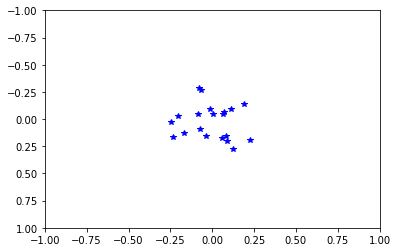

In [28]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu, bu, -bv, bv])
plt.gca().invert_yaxis()
plt.show()

## Interactive display of view from different camera positions and orientations 

In [29]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(transform_camera, p=fixed(p),
         x    = (-1.0,+1.0,0.01), y     = (-1.0,+1.0,0.01), z = (0.0,+2.0,0.01),
         roll = (-pi,+pi,0.01),   pitch = (-pi,+pi,0.01),   yaw = (-pi,+pi,0.01),
         f=fixed(1), bu=fixed(1), bv=fixed(1), u0=fixed(0), v0=fixed(0)
        ) 

A Jupyter Widget

<function helpers.transform_camera>

-------------------------
## Part II: Particle Filter with TR as E matrix (assume K = I)

1. Set up two camera positions (translation and rotation)
2. Sample possible translation and rotation in 3 dimensions each, using particle filtering

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
[0.  0.  1.1]


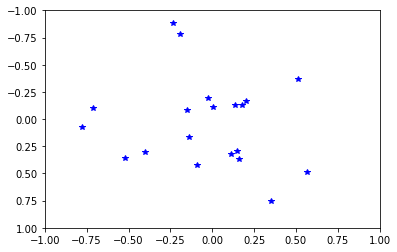

[[ 0.9605305   0.23339191 -0.15135845]
 [-0.19470917  0.95268912  0.23339191]
 [ 0.19866933 -0.19470917  0.9605305 ]]
[-0.2 -0.2  0.9]


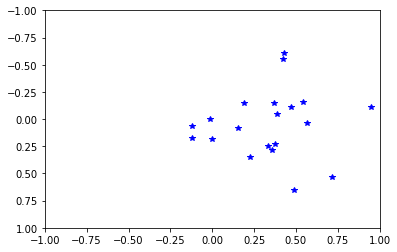

In [30]:
# Set up two camera positions

diff = -0.2
pts1 = transform_camera(p, x=0, y=0, z=1.1, roll=0, pitch=0, yaw=0)
pts2 = transform_camera(p, x=diff, y=diff, z=1.1+diff, roll=diff, pitch=diff, yaw=diff)

#### List pts1 and pts2:

In [31]:
pts1

array([[-0.15137393, -0.08655125],
       [ 0.34846594,  0.7576652 ],
       [ 0.10917377,  0.32220089],
       [-0.19235893, -0.7809593 ],
       [ 0.50961295, -0.3731047 ],
       [ 0.00415144, -0.10900957],
       [ 0.15776777,  0.36579492],
       [ 0.20254274, -0.16824478],
       [-0.52218413,  0.35498679],
       [-0.39895244,  0.30459808],
       [-0.02370651, -0.1925867 ],
       [-0.09256147,  0.418915  ],
       [-0.14147754,  0.16925879],
       [ 0.13455305, -0.12732354],
       [-0.23502954, -0.88291445],
       [ 0.17640944, -0.12622378],
       [ 0.56869401,  0.48996385],
       [ 0.14981377,  0.29142496],
       [-0.71403296, -0.10296637],
       [-0.77971538,  0.07674627]])

In [32]:
pts2

array([[ 1.88184068e-01, -1.51768713e-01],
       [ 4.91012526e-01,  6.53602568e-01],
       [ 3.32255707e-01,  2.48813369e-01],
       [ 4.25456179e-01, -5.55378579e-01],
       [ 9.46616275e-01, -1.08060676e-01],
       [ 3.84137863e-01, -5.08018822e-02],
       [ 3.58402058e-01,  2.86627835e-01],
       [ 5.44083746e-01, -1.54648270e-01],
       [-1.19604185e-01,  1.76318719e-01],
       [-2.19577455e-03,  1.84825641e-01],
       [ 3.66427687e-01, -1.52329528e-01],
       [ 2.27325697e-01,  3.45012567e-01],
       [ 1.56572076e-01,  7.93661781e-02],
       [ 4.71637980e-01, -1.14649397e-01],
       [ 4.28017386e-01, -6.11479055e-01],
       [ 5.67795254e-01,  3.83879015e-02],
       [ 7.16743605e-01,  5.30255301e-01],
       [ 3.73173182e-01,  2.32986922e-01],
       [-1.37924419e-02, -6.19769203e-04],
       [-1.21263908e-01,  5.91154261e-02]])

### Test sampling and scatterplot display functions

In [33]:
from helpers import generate_xyz_rpy

# Sample m states. Shape of S: (4, n_samples)
m = 100
S = np.concatenate((generate_xyz_rpy(m, -0.5, 0.5, -pi/4, pi/4), 1/m * np.ones((1,m))), axis = 0) 

print("Shape of initial S: " + str(S.shape))

Shape of initial S: (7, 100)


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


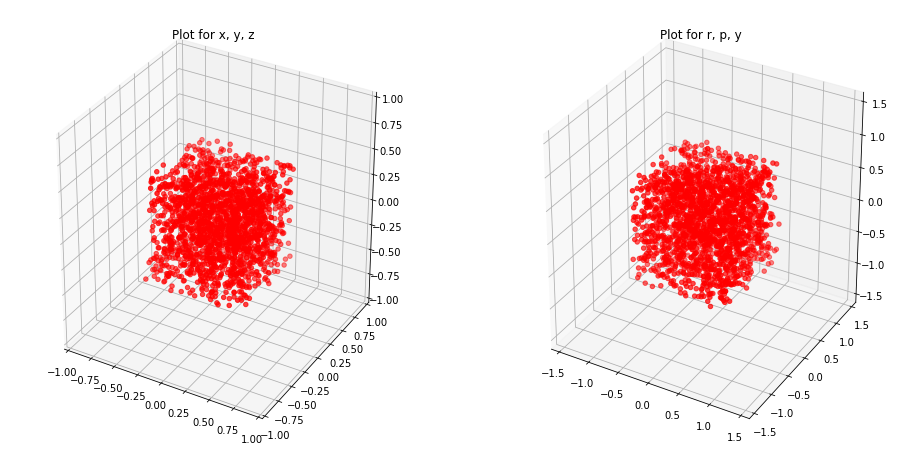

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*S[:3,:], zdir='z', c= 'red')
ax1.set_xlim3d(-1, 1)
ax1.set_ylim3d(-1, 1)
ax1.set_zlim3d(-1, 1)
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S[3:,:], c= 'red')
ax2.set_xlim3d(-pi/2, pi/2)
ax2.set_ylim3d(-pi/2, pi/2)
ax2.set_zlim3d(-pi/2, pi/2)
ax2.set_title("Plot for r, p, y")
plt.show()

###  Run Particle Filter

C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


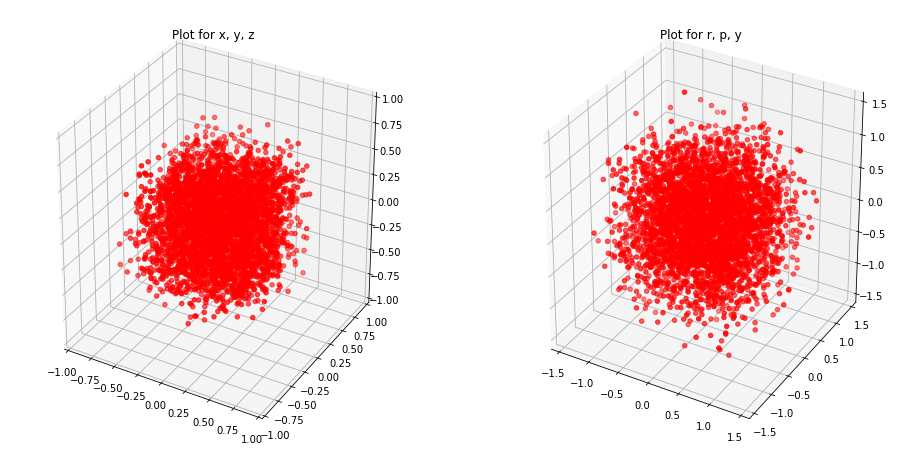

First 200 scores: [0, 5, 2, 1, 0, 0, 2, 3, 7, 0, 3, 2, 2, 0, 0, 0, 0, 4, 3, 1, 4, 1, 4, 0, 3, 0, 1, 3, 3, 0, 3, 1, 8, 2, 1, 4, 2, 2, 3, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1, 0, 0, 0, 5, 1, 1, 0, 5, 1, 4, 3, 1, 0, 0, 5, 6, 2, 1, 0, 8, 4, 0, 1, 1, 0, 3, 0, 0, 3, 1, 2, 5, 0, 2, 1, 3, 5, 3, 2, 1, 0, 1, 4, 1, 3, 4, 2, 0, 1, 4, 2, 0, 1, 3, 3, 7, 1, 1, 1, 6, 2, 1, 3, 0, 1, 5, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0, 4, 1, 3, 1, 1, 3, 6, 2, 4, 3, 3, 1, 5, 1, 3, 1, 6, 0, 3, 2, 2, 0, 0, 1, 3, 0, 4, 2, 5, 0, 2, 0, 0, 5, 2, 0, 1, 1, 0, 2, 3, 1, 0, 1, 0, 1, 0, 1, 7, 2, 3, 0, 3, 4, 3, 7, 1, 0, 2, 5, 4, 5, 3, 0, 0, 0, 1, 0, 1, 3, 2, 1, 3, 0]
Non-match ratio: 0.944790 (6845/7245)
Sigma (xyz): 0.100000  Sigma (rpy): 0.300000
Epsilon: 0.000050
Iteration: 1


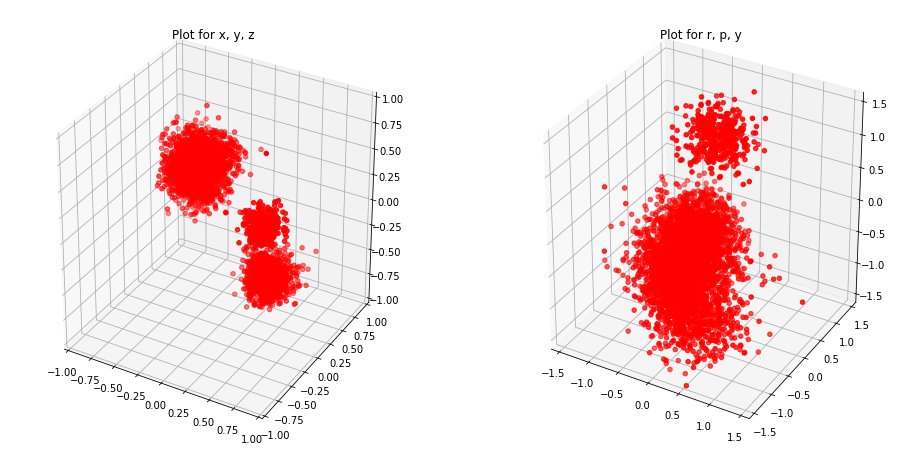

First 200 scores: [0, 2, 0, 1, 0, 5, 2, 1, 2, 0, 0, 3, 1, 4, 5, 1, 6, 10, 0, 4, 3, 2, 7, 3, 2, 2, 4, 7, 2, 2, 3, 6, 1, 1, 6, 4, 2, 4, 4, 4, 6, 3, 0, 1, 0, 2, 6, 1, 4, 6, 2, 2, 2, 2, 1, 3, 3, 4, 7, 8, 5, 5, 0, 1, 2, 1, 5, 2, 5, 0, 1, 2, 3, 4, 4, 0, 2, 2, 0, 0, 4, 3, 4, 1, 0, 3, 0, 3, 2, 1, 3, 1, 0, 4, 0, 0, 2, 6, 10, 5, 11, 7, 3, 5, 1, 3, 3, 9, 3, 2, 1, 5, 8, 1, 6, 0, 0, 1, 1, 4, 1, 5, 4, 0, 8, 1, 0, 6, 1, 0, 6, 2, 3, 1, 0, 0, 2, 4, 1, 2, 3, 1, 5, 4, 1, 1, 6, 1, 11, 2, 0, 4, 6, 11, 6, 3, 3, 5, 1, 4, 1, 2, 2, 3, 1, 3, 0, 0, 5, 1, 3, 8, 7, 2, 1, 4, 3, 2, 1, 9, 1, 0, 5, 1, 3, 6, 6, 5, 4, 8, 0, 2, 0, 4, 5, 4, 8, 7, 2, 1]
Non-match ratio: 0.951773 (11328/11902)
Sigma (xyz): 0.080000  Sigma (rpy): 0.240000
Epsilon: 0.000050
Iteration: 6


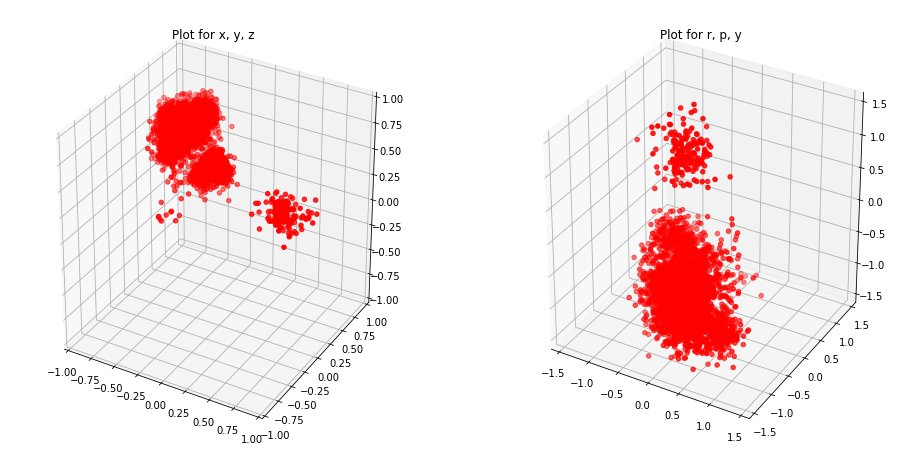

First 200 scores: [0, 2, 5, 1, 0, 0, 0, 2, 5, 0, 3, 0, 0, 7, 1, 2, 0, 5, 0, 4, 5, 6, 2, 5, 1, 2, 0, 8, 8, 6, 5, 3, 0, 5, 2, 0, 2, 3, 0, 3, 2, 0, 2, 10, 4, 1, 2, 10, 1, 6, 5, 1, 4, 4, 3, 0, 11, 1, 4, 2, 4, 6, 2, 2, 1, 2, 1, 2, 7, 4, 1, 4, 5, 2, 0, 0, 1, 0, 1, 0, 6, 4, 2, 4, 1, 8, 2, 4, 7, 2, 6, 2, 7, 1, 1, 0, 1, 2, 1, 2, 0, 1, 3, 3, 0, 7, 14, 6, 5, 13, 6, 4, 1, 3, 12, 1, 9, 4, 4, 1, 6, 3, 1, 7, 3, 2, 4, 2, 1, 1, 1, 1, 3, 0, 4, 2, 1, 11, 3, 2, 0, 4, 5, 0, 5, 2, 5, 4, 3, 15, 2, 4, 1, 3, 1, 1, 5, 2, 4, 6, 1, 10, 3, 2, 5, 7, 3, 4, 0, 1, 7, 1, 3, 3, 0, 3, 9, 4, 0, 6, 8, 3, 2, 3, 8, 4, 4, 1, 3, 1, 3, 4, 1, 0, 4, 4, 0, 2, 2, 0]
Non-match ratio: 0.948767 (13852/14600)
Sigma (xyz): 0.051200  Sigma (rpy): 0.153600
Epsilon: 0.000045
Iteration: 11


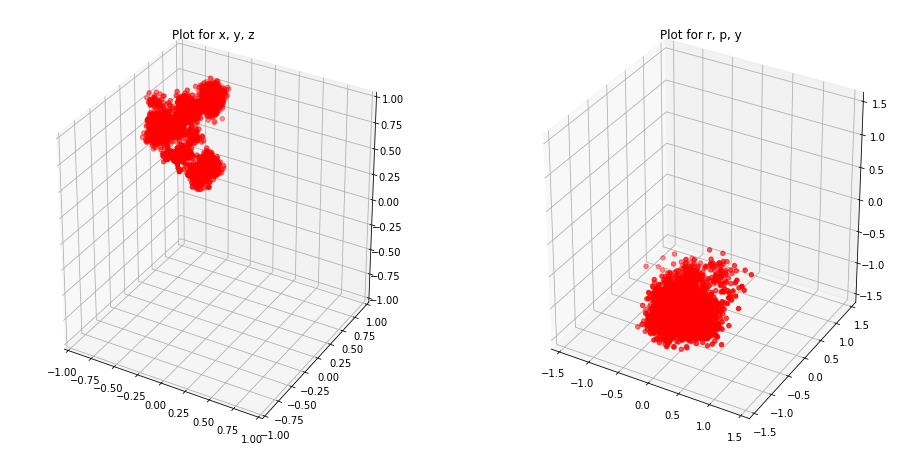

First 200 scores: [10, 12, 4, 3, 4, 12, 3, 1, 3, 2, 7, 1, 2, 8, 7, 4, 0, 0, 3, 1, 12, 4, 17, 5, 3, 13, 8, 7, 2, 9, 0, 5, 11, 4, 14, 19, 2, 15, 10, 1, 7, 0, 1, 9, 2, 1, 3, 5, 1, 2, 3, 3, 4, 10, 3, 0, 10, 9, 1, 1, 10, 2, 3, 1, 6, 0, 7, 7, 1, 2, 1, 9, 2, 3, 2, 1, 9, 2, 11, 5, 3, 4, 2, 1, 7, 8, 1, 9, 2, 5, 1, 6, 9, 3, 2, 4, 11, 3, 2, 12, 1, 3, 11, 1, 0, 7, 4, 9, 10, 2, 2, 5, 3, 0, 1, 2, 1, 0, 0, 5, 3, 9, 0, 0, 11, 2, 8, 11, 0, 8, 5, 8, 9, 1, 6, 0, 5, 0, 9, 15, 3, 10, 1, 3, 0, 3, 2, 2, 3, 6, 4, 6, 3, 1, 3, 4, 6, 3, 1, 1, 4, 4, 6, 20, 0, 2, 4, 1, 8, 7, 7, 3, 2, 11, 8, 2, 1, 0, 2, 2, 5, 1, 3, 4, 4, 2, 0, 3, 3, 6, 7, 1, 8, 0, 1, 4, 5, 0, 4, 3]
Non-match ratio: 0.950631 (15982/16812)
Sigma (xyz): 0.032768  Sigma (rpy): 0.098304
Epsilon: 0.000045
Iteration: 16


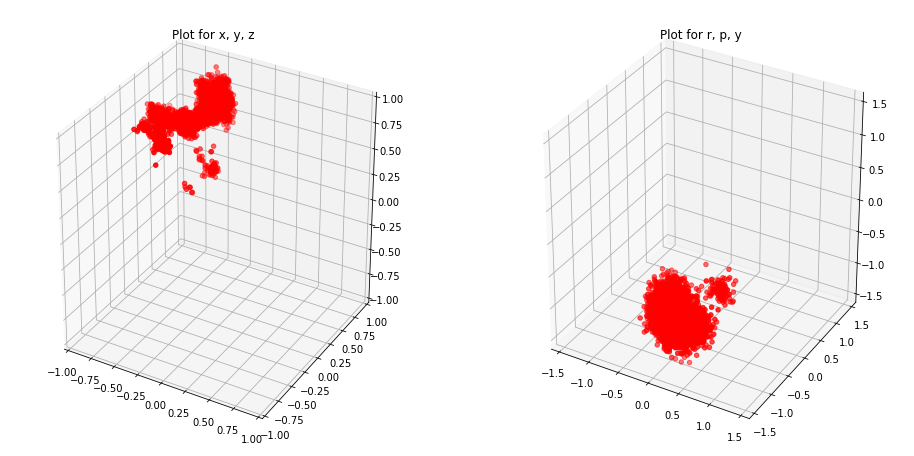

First 200 scores: [2, 2, 2, 2, 7, 2, 2, 3, 3, 1, 4, 0, 12, 13, 8, 20, 8, 2, 1, 1, 0, 1, 1, 3, 6, 2, 3, 12, 2, 2, 1, 5, 8, 0, 6, 5, 5, 6, 1, 9, 3, 6, 0, 7, 5, 11, 4, 4, 1, 17, 4, 3, 7, 4, 3, 1, 2, 14, 4, 3, 1, 11, 5, 3, 2, 0, 10, 5, 3, 7, 13, 8, 3, 4, 3, 0, 4, 7, 4, 5, 5, 7, 7, 18, 9, 1, 5, 2, 11, 6, 4, 1, 8, 12, 5, 1, 5, 1, 0, 18, 3, 1, 3, 5, 6, 3, 3, 1, 2, 7, 2, 7, 8, 9, 1, 3, 0, 6, 1, 3, 5, 1, 0, 7, 10, 2, 6, 4, 1, 1, 7, 7, 5, 2, 2, 11, 2, 10, 1, 5, 2, 0, 2, 20, 4, 8, 2, 8, 3, 8, 9, 8, 6, 0, 1, 4, 1, 6, 11, 6, 3, 7, 2, 2, 20, 6, 4, 3, 3, 14, 9, 1, 0, 7, 5, 5, 0, 1, 9, 3, 6, 3, 7, 9, 8, 3, 13, 2, 12, 5, 3, 5, 7, 6, 2, 2, 2, 4, 7, 11]
Non-match ratio: 0.953685 (18800/19713)
Sigma (xyz): 0.026214  Sigma (rpy): 0.078643
Epsilon: 0.000041
Iteration: 21


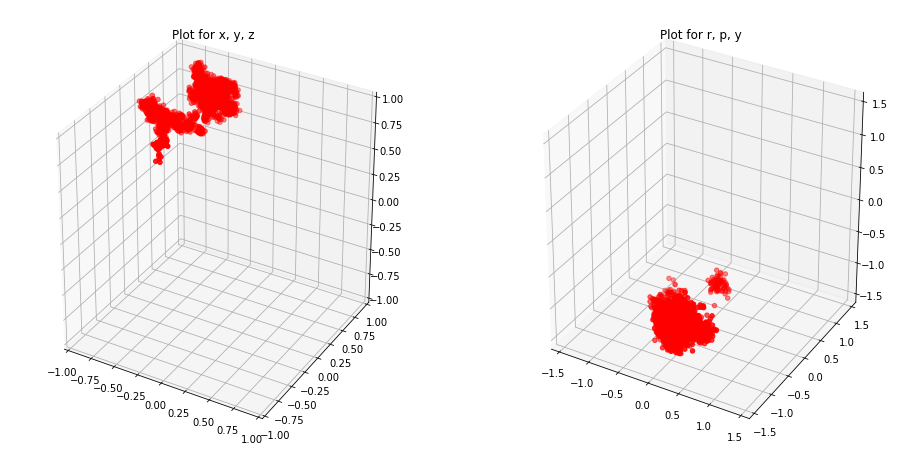

First 200 scores: [5, 0, 9, 12, 5, 7, 1, 19, 3, 7, 8, 4, 2, 12, 8, 4, 5, 4, 19, 10, 11, 18, 6, 20, 6, 12, 20, 19, 4, 16, 6, 10, 3, 20, 3, 3, 3, 5, 12, 7, 9, 8, 6, 12, 1, 9, 1, 0, 3, 4, 9, 8, 14, 6, 3, 6, 9, 5, 8, 10, 13, 7, 7, 5, 4, 3, 3, 4, 8, 5, 2, 10, 9, 5, 6, 3, 14, 17, 7, 2, 1, 4, 4, 3, 4, 7, 1, 7, 11, 9, 4, 6, 11, 11, 18, 5, 3, 10, 4, 3, 4, 5, 4, 3, 5, 0, 0, 17, 4, 2, 5, 3, 6, 11, 2, 7, 2, 4, 2, 9, 3, 3, 11, 4, 7, 4, 3, 11, 3, 8, 0, 8, 1, 1, 1, 2, 5, 19, 3, 7, 6, 7, 5, 2, 8, 6, 8, 4, 9, 16, 7, 2, 20, 3, 6, 3, 2, 3, 2, 6, 2, 4, 7, 3, 7, 4, 4, 2, 10, 4, 10, 12, 4, 7, 10, 0, 5, 0, 2, 9, 3, 8, 18, 4, 2, 8, 0, 5, 7, 11, 14, 10, 3, 6, 7, 6, 3, 3, 2, 0]
Non-match ratio: 0.954357 (23962/25108)
Sigma (xyz): 0.016777  Sigma (rpy): 0.050332
Epsilon: 0.000041
Iteration: 26


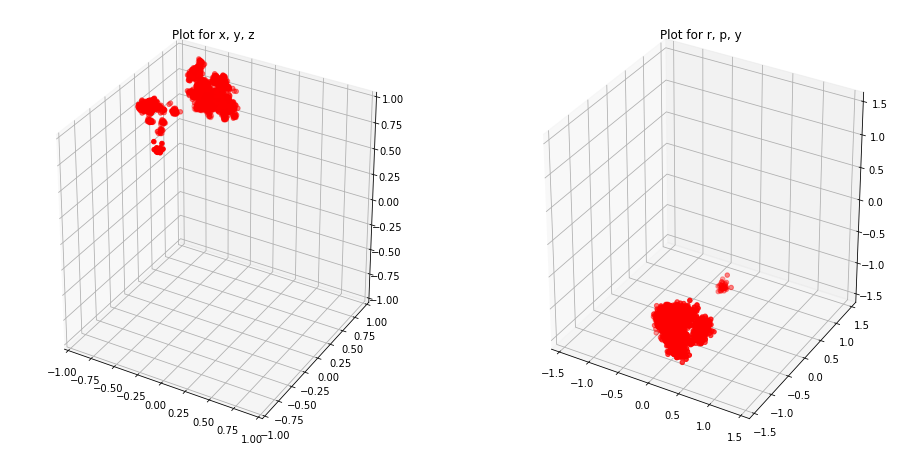

First 200 scores: [9, 7, 8, 10, 10, 15, 12, 3, 9, 4, 6, 8, 2, 5, 20, 4, 2, 1, 3, 2, 18, 3, 7, 9, 7, 8, 2, 3, 8, 6, 6, 7, 0, 10, 7, 4, 19, 16, 16, 5, 18, 4, 7, 12, 7, 9, 10, 7, 7, 4, 10, 18, 8, 1, 9, 7, 9, 16, 6, 4, 8, 0, 11, 9, 4, 16, 15, 11, 1, 6, 11, 13, 9, 8, 8, 10, 3, 7, 4, 2, 10, 9, 0, 20, 5, 3, 13, 2, 7, 14, 11, 2, 0, 20, 10, 4, 5, 20, 15, 5, 7, 10, 8, 8, 12, 2, 13, 1, 10, 8, 8, 5, 3, 16, 6, 2, 7, 5, 6, 11, 8, 4, 18, 12, 6, 2, 5, 2, 3, 5, 19, 0, 5, 10, 5, 0, 20, 13, 4, 9, 12, 7, 11, 4, 1, 5, 11, 13, 3, 1, 12, 17, 12, 6, 17, 3, 3, 4, 2, 13, 7, 1, 2, 7, 5, 6, 1, 0, 8, 4, 8, 12, 1, 8, 6, 13, 8, 11, 13, 8, 2, 20, 19, 15, 17, 3, 4, 14, 12, 9, 12, 18, 2, 8, 6, 1, 4, 5, 0, 9]
Non-match ratio: 0.958766 (28879/30121)
Sigma (xyz): 0.010737  Sigma (rpy): 0.032212
Epsilon: 0.000036
Iteration: 31


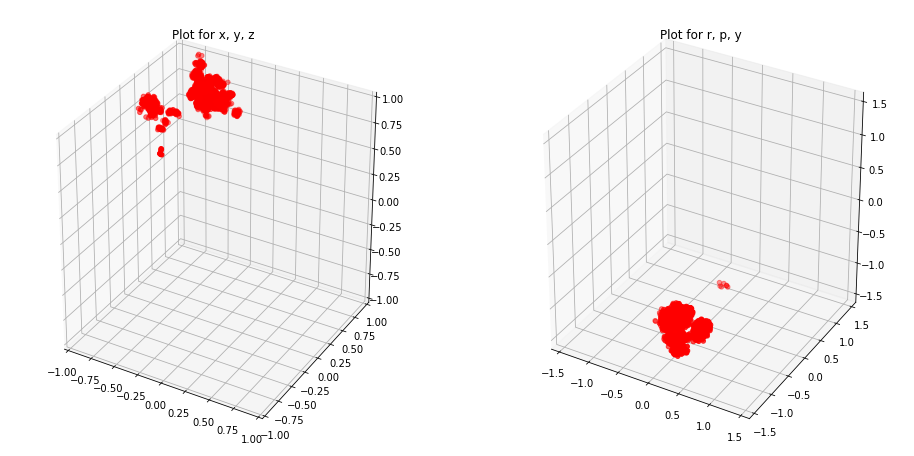

First 200 scores: [13, 20, 7, 4, 9, 3, 1, 8, 11, 6, 20, 13, 5, 20, 14, 9, 6, 5, 5, 2, 4, 4, 8, 13, 12, 3, 5, 7, 1, 3, 13, 0, 1, 10, 4, 7, 5, 7, 13, 7, 9, 4, 2, 6, 4, 13, 9, 2, 20, 10, 19, 19, 7, 10, 9, 5, 6, 7, 6, 6, 5, 6, 17, 1, 16, 10, 2, 19, 8, 8, 5, 11, 8, 2, 6, 2, 8, 20, 6, 6, 8, 9, 6, 5, 2, 9, 5, 12, 11, 10, 2, 6, 4, 1, 6, 10, 10, 3, 16, 3, 0, 17, 16, 6, 14, 11, 10, 2, 9, 10, 11, 4, 4, 18, 1, 3, 18, 5, 7, 1, 2, 16, 7, 6, 7, 6, 18, 0, 5, 6, 2, 2, 11, 2, 5, 7, 1, 3, 12, 8, 6, 1, 5, 10, 1, 2, 11, 5, 9, 8, 6, 14, 4, 3, 13, 9, 8, 8, 7, 1, 3, 15, 17, 9, 8, 13, 14, 2, 15, 5, 9, 10, 10, 2, 9, 5, 9, 9, 6, 1, 8, 13, 12, 12, 8, 15, 2, 1, 10, 2, 4, 9, 11, 4, 7, 10, 6, 18, 7, 12]
Non-match ratio: 0.956469 (31618/33057)
Sigma (xyz): 0.008590  Sigma (rpy): 0.025770
Epsilon: 0.000036
Iteration: 36


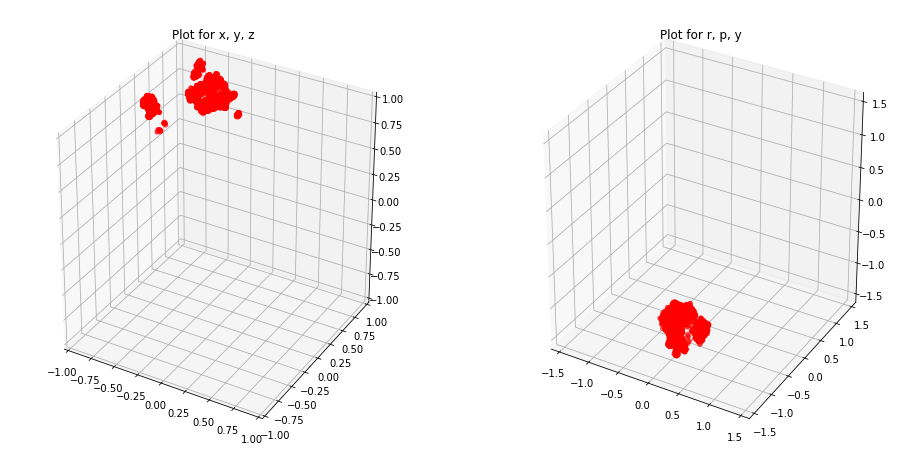

First 200 scores: [10, 15, 18, 2, 8, 6, 20, 8, 17, 9, 20, 8, 15, 3, 12, 6, 4, 7, 20, 12, 0, 1, 8, 11, 4, 2, 14, 5, 10, 10, 8, 4, 19, 13, 12, 3, 9, 16, 17, 13, 10, 7, 13, 3, 2, 17, 12, 10, 10, 7, 17, 6, 13, 9, 12, 20, 15, 8, 13, 12, 15, 13, 16, 7, 14, 19, 2, 9, 7, 13, 19, 20, 7, 3, 20, 9, 19, 11, 4, 19, 8, 17, 14, 9, 9, 5, 14, 14, 20, 0, 16, 11, 12, 19, 6, 14, 4, 6, 11, 4, 4, 20, 12, 6, 9, 6, 8, 13, 11, 6, 6, 13, 5, 5, 20, 5, 13, 14, 9, 14, 7, 20, 6, 5, 11, 18, 19, 11, 16, 2, 1, 12, 20, 11, 7, 9, 13, 17, 20, 9, 10, 11, 10, 16, 17, 1, 20, 13, 4, 14, 12, 7, 4, 6, 13, 8, 12, 11, 14, 19, 20, 2, 18, 10, 11, 20, 10, 11, 12, 5, 18, 9, 17, 9, 4, 2, 7, 20, 10, 12, 6, 10, 13, 8, 11, 7, 8, 5, 4, 0, 13, 6, 4, 20, 13, 3, 5, 6, 9, 7]
Non-match ratio: 0.952731 (36985/38820)
Sigma (xyz): 0.005498  Sigma (rpy): 0.016493
Epsilon: 0.000033
Iteration: 41


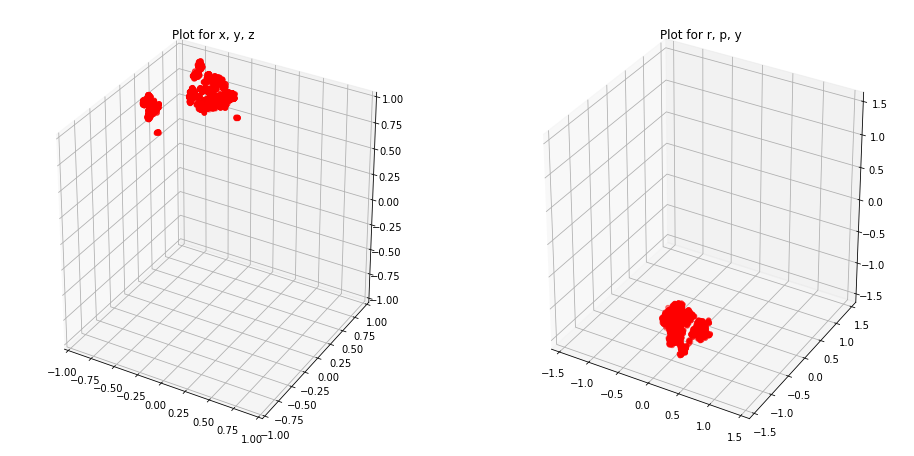

First 200 scores: [7, 5, 18, 14, 13, 11, 5, 20, 20, 19, 11, 11, 3, 13, 12, 7, 9, 4, 13, 9, 6, 17, 9, 15, 5, 9, 14, 11, 19, 9, 3, 5, 14, 9, 20, 20, 18, 14, 9, 6, 12, 15, 18, 3, 17, 10, 7, 7, 6, 10, 8, 12, 11, 7, 5, 18, 11, 12, 10, 11, 11, 0, 18, 10, 12, 20, 17, 19, 7, 14, 3, 10, 14, 17, 9, 20, 7, 19, 10, 9, 12, 10, 10, 11, 4, 2, 10, 20, 1, 20, 7, 11, 3, 13, 8, 20, 20, 3, 20, 5, 7, 4, 8, 15, 9, 9, 14, 20, 8, 11, 16, 2, 16, 19, 20, 12, 14, 11, 18, 10, 10, 20, 13, 13, 20, 7, 11, 9, 11, 19, 2, 15, 18, 19, 11, 15, 7, 19, 3, 16, 12, 20, 20, 6, 20, 14, 10, 11, 14, 19, 10, 19, 9, 4, 13, 13, 7, 8, 7, 14, 8, 5, 10, 11, 20, 12, 20, 8, 14, 6, 4, 12, 14, 2, 6, 6, 20, 8, 16, 8, 16, 4, 5, 20, 8, 13, 20, 15, 7, 18, 15, 3, 6, 16, 9, 20, 20, 6, 6, 19]
Non-match ratio: 0.955160 (43412/45450)
Sigma (xyz): 0.003518  Sigma (rpy): 0.010555
Epsilon: 0.000033
Iteration: 46


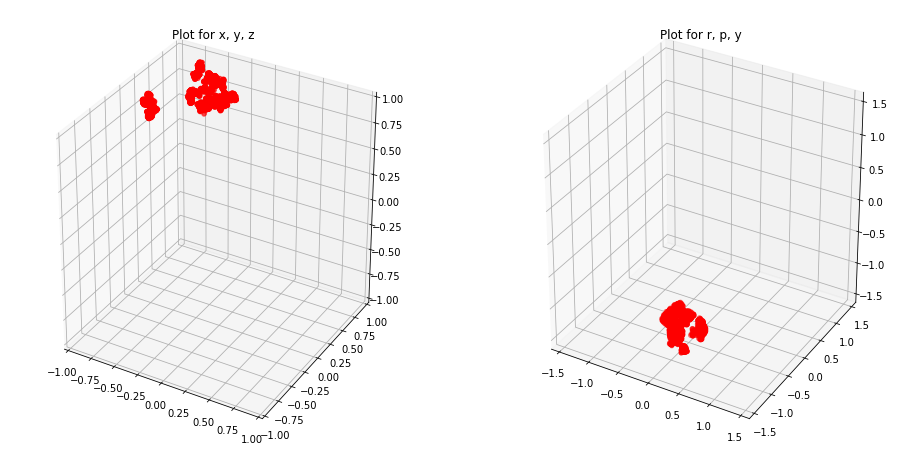

First 200 scores: [8, 17, 16, 17, 20, 7, 16, 4, 6, 6, 3, 10, 9, 13, 13, 3, 6, 17, 13, 20, 20, 12, 15, 14, 13, 20, 20, 5, 7, 8, 10, 10, 12, 6, 13, 9, 20, 20, 8, 14, 18, 8, 5, 18, 6, 10, 6, 8, 18, 5, 18, 10, 17, 12, 11, 12, 13, 19, 5, 6, 12, 19, 6, 12, 20, 8, 10, 9, 10, 3, 11, 11, 7, 6, 10, 20, 8, 20, 12, 14, 10, 8, 11, 11, 7, 20, 16, 7, 9, 15, 10, 20, 15, 5, 10, 2, 8, 7, 20, 11, 20, 14, 2, 15, 8, 20, 20, 5, 12, 6, 8, 15, 11, 4, 20, 3, 5, 15, 20, 13, 12, 9, 7, 17, 7, 20, 8, 15, 6, 10, 13, 12, 11, 20, 16, 20, 6, 2, 15, 9, 11, 10, 6, 6, 5, 10, 6, 9, 11, 17, 8, 20, 9, 20, 7, 8, 4, 8, 12, 8, 3, 16, 12, 7, 12, 8, 16, 10, 14, 10, 9, 8, 5, 12, 9, 5, 8, 14, 14, 7, 7, 14, 20, 9, 6, 10, 6, 7, 17, 20, 10, 20, 8, 12, 10, 20, 17, 15, 13, 2]
Non-match ratio: 0.954847 (45360/47505)
Sigma (xyz): 0.002815  Sigma (rpy): 0.008444
Epsilon: 0.000030
Iteration: 51


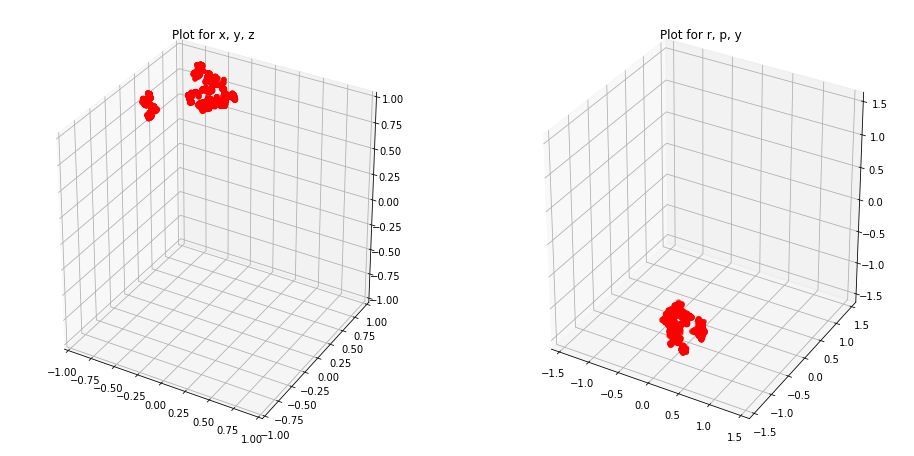

First 200 scores: [20, 20, 19, 14, 20, 20, 20, 18, 20, 20, 20, 12, 18, 13, 12, 8, 15, 15, 20, 6, 8, 9, 6, 20, 18, 13, 19, 19, 16, 20, 19, 20, 6, 17, 12, 7, 6, 20, 20, 18, 20, 20, 9, 20, 7, 4, 10, 14, 20, 10, 20, 20, 20, 7, 20, 20, 20, 9, 19, 20, 20, 20, 15, 13, 13, 20, 20, 8, 17, 20, 3, 11, 11, 12, 15, 18, 13, 20, 20, 6, 20, 20, 8, 8, 16, 13, 10, 18, 20, 20, 4, 12, 20, 20, 11, 13, 9, 9, 19, 4, 17, 19, 18, 8, 19, 13, 20, 20, 20, 19, 20, 9, 4, 12, 20, 8, 20, 11, 6, 20, 7, 14, 7, 18, 11, 12, 20, 10, 8, 4, 7, 13, 10, 10, 9, 18, 20, 13, 20, 20, 19, 14, 9, 18, 20, 20, 20, 20, 6, 10, 6, 8, 20, 8, 20, 9, 3, 17, 8, 7, 7, 20, 3, 20, 20, 18, 20, 20, 13, 15, 20, 5, 20, 20, 8, 11, 20, 20, 8, 11, 9, 5, 20, 9, 14, 6, 14, 5, 19, 20, 10, 8, 17, 13, 18, 20, 15, 9, 12, 11]
Non-match ratio: 0.954100 (52964/55512)
Sigma (xyz): 0.001801  Sigma (rpy): 0.005404
Epsilon: 0.000030
Iteration: 56


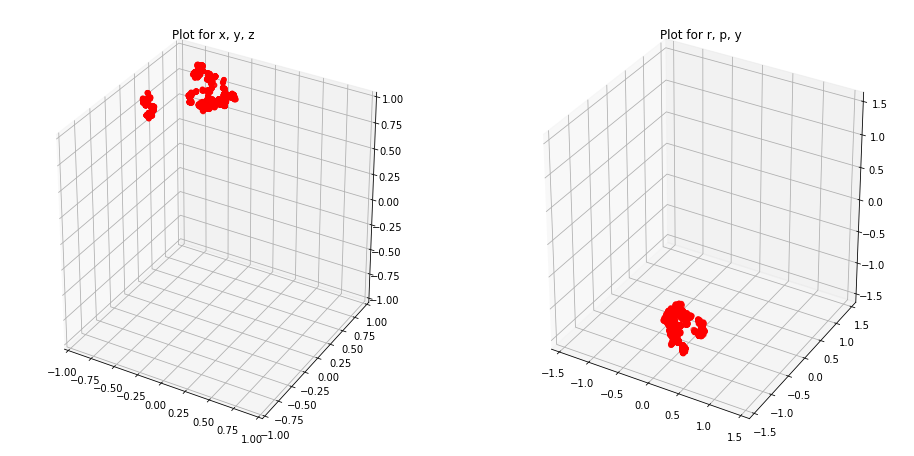

First 200 scores: [20, 20, 20, 20, 12, 3, 3, 13, 18, 8, 20, 13, 5, 11, 20, 20, 20, 6, 20, 12, 20, 11, 19, 20, 20, 13, 11, 7, 20, 19, 8, 12, 16, 7, 17, 20, 20, 20, 6, 14, 11, 8, 20, 20, 9, 8, 10, 20, 11, 13, 4, 20, 9, 15, 18, 20, 7, 20, 6, 20, 18, 14, 11, 12, 9, 20, 15, 16, 20, 20, 7, 18, 7, 12, 20, 20, 10, 5, 20, 20, 20, 20, 20, 8, 6, 11, 20, 20, 20, 20, 19, 11, 20, 19, 15, 14, 7, 20, 20, 20, 11, 12, 5, 20, 20, 20, 20, 5, 20, 9, 16, 18, 6, 20, 18, 14, 19, 11, 17, 10, 20, 20, 19, 13, 18, 20, 3, 7, 17, 19, 18, 20, 20, 18, 20, 20, 7, 17, 14, 7, 9, 5, 20, 20, 8, 19, 6, 20, 12, 13, 18, 20, 12, 6, 6, 20, 11, 17, 20, 12, 13, 6, 8, 20, 20, 15, 20, 20, 19, 11, 7, 20, 9, 19, 20, 19, 13, 20, 20, 10, 19, 6, 19, 14, 20, 20, 6, 8, 10, 20, 20, 11, 7, 20, 5, 15, 20, 20, 6, 20]
Non-match ratio: 0.954409 (56795/59508)
Sigma (xyz): 0.001441  Sigma (rpy): 0.004323
Epsilon: 0.000030
Iteration: 60


In [50]:
from helpers import ParticleFilter, generate_xyz_rpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

iterations = 60

m = 4000
S = np.concatenate((generate_xyz_rpy(m, -0.5, 0.5, -pi/4, pi/4), 1/m * np.ones((1,m))), axis = 0) 

S_new = S
e = 0.00005
sigma_xyz = 0.1
sigma_rpy = 0.3

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma_xyz, sigma_rpy, pts1, pts2, epsilon = e)
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (16,8))

        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(*S_new[:3,:], c= 'red')
        ax1.set_xlim3d(-1, 1)
        ax1.set_ylim3d(-1, 1)
        ax1.set_zlim3d(-1, 1)
        ax1.set_title("Plot for x, y, z")

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(*S_new[3:,:], c= 'red')
        ax2.set_xlim3d(-pi/2, pi/2)
        ax2.set_ylim3d(-pi/2, pi/2)
        ax2.set_zlim3d(-pi/2, pi/2)
        ax2.set_title("Plot for r, p, y")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma (xyz): %f  Sigma (rpy): %f" % (sigma_xyz, sigma_rpy))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
    
    # Decrease sigma over iterations
    if (i+1)%3 == 0:
        sigma_xyz *= 0.8
        sigma_rpy *= 0.8
    
    # Decrease epsilon over iterations
    if (i+1)%10 == 0:
        e *= 0.9
        
    # Increase sigma and epsilon if all solutions have too few matches (< 30%), usually when epsilon is small 
    # if max(score_list) < pts1.shape[0]*0.3:
    #     sigma_xyz *= 1.3
    #     sigma_rpy *= 1.3
        
    if score_list.count(pts1.shape[0]) > m/2: 
        break
    

### 4. Recover solution from Particle Filter

In [51]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
print("Average: " + str(ave))

Average: [-0.74816599  0.9283785   0.59846871  0.19501744 -1.05713991 -1.0162995 ]


In [52]:
# Compare translation with ground truth by normalising both vectors
gt = np.array([diff, diff, diff])
t  = ave[:3]
print("Solution t:   " + str(t/np.linalg.norm(t)))
print("Ground truth: " + str(gt/np.linalg.norm(gt)))
print("Difference:   " + str(t/np.linalg.norm(t) - gt/np.linalg.norm(gt)))

Solution t:   [-0.56080503  0.69588746  0.44859599]
Ground truth: [-0.57735027 -0.57735027 -0.57735027]
Difference:   [0.01654524 1.27323773 1.02594626]


In [59]:
# Compare rotation with ground truth by taking modulo wrt. 2pi
r = ave[3:] % (2*pi)
gt = np.array([diff, diff, diff]) % (2*pi)

print("Solution r:   " + str(r))
print("Ground truth: " + str(gt))

diff_r = np.minimum((r - gt) % (2*pi), (gt - r) % (2*pi))

print("Difference:   " + str(diff_r))

Solution r:   [0.19501744 5.2260454  5.26688581]
Ground truth: [6.08318531 6.08318531 6.08318531]
Difference:   [0.39501744 0.85713991 0.8162995 ]


In [54]:
# Construct E from solution t and r, check that (pts1)' T (pts2) = 0

from helpers import rpy2R

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

T = np.array([[     0, -t[2],  t[1] ],
              [  t[2],     0, -t[0] ],
              [ -t[1],  t[0],     0 ]])

R = rpy2R(r[0], r[1], r[2])

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)

0.00668411022465594
-0.8855282147800843
-0.453358011499314
0.025343667010190585
-0.4474499008820715
-0.22386412949295745
-0.5013288674526073
-0.18071369930391093
-0.017617532413488263
-0.13183182355578507
-0.12488301862828671
-0.46965824192722094
-0.188197728157953
-0.1910959662630156
0.025497413321385998
-0.41802758403071216
-0.8038461834911124
-0.45448969608995893
0.149701156937527
0.2225967166165615


In [55]:
# Ground truth check of (pts1)' T (pts2) = 0 for comparison

t = np.array([diff, diff, diff, diff, diff, diff])

T = np.array([[     0, -t[2],  t[1] ],
              [  t[2],     0, -t[0] ],
              [ -t[1],  t[0],     0 ]])

R = rpy2R(t[3], t[4], t[5])

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)


2.7755575615628914e-17
1.3877787807814457e-17
-1.3877787807814457e-17
5.551115123125783e-17
2.7755575615628914e-17
0.0
-6.938893903907228e-18
2.7755575615628914e-17
1.3877787807814457e-17
-2.0816681711721685e-17
1.3877787807814457e-17
0.0
-3.469446951953614e-18
-1.3877787807814457e-17
5.551115123125783e-17
2.7755575615628914e-17
6.938893903907228e-18
0.0
1.0408340855860843e-17
0.0
